# SARIMAX

In [9]:
import json
import sys
sys.path.append('../')  # Go up to src/ directory

import numpy as np
from dataset import load_and_preprocess_sarimax_data
from models import SARIMAX_model
import warnings
warnings.filterwarnings('ignore')   

# Data Setup

In [2]:
df = load_and_preprocess_sarimax_data('../../data/energy_data.csv')

target = 'spot'
exog_vars = ['wind_forecast_dah_mw', 'consumption_forecast_dah_mw', 
             'temp_forecast_dah_celcius', 'temp_norm_celcius',
             'heating_demand_interaction', 'temp_deviation', 'spot_lag1']

# Train/test split (80/20)
split_idx = int(len(df) * 0.8)
train_data = df.iloc[:split_idx].copy()
test_data = df.iloc[split_idx:].copy()

y_train = train_data[target].values
X_train = train_data[exog_vars].values

y_test = test_data[target].values
X_test = test_data[exog_vars].values

# SARIMAX parameter search

In [3]:
model = SARIMAX_model().auto_train(y_train, X_train, seasonal=True, m=24)
model.save("SARIMAX_model.json")

Running auto_arima to find best parameters...
Performing stepwise search to minimize bic
 ARIMA(0,1,0)(0,0,0)[24] intercept   : BIC=64223.551, Time=0.04 sec
 ARIMA(1,1,0)(1,0,0)[24] intercept   : BIC=61961.891, Time=4.45 sec
 ARIMA(0,1,1)(0,0,1)[24] intercept   : BIC=62511.321, Time=4.01 sec
 ARIMA(0,1,0)(0,0,0)[24]             : BIC=64214.697, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[24] intercept   : BIC=63378.195, Time=0.09 sec
 ARIMA(1,1,0)(1,0,1)[24] intercept   : BIC=inf, Time=7.93 sec
 ARIMA(1,1,0)(0,0,1)[24] intercept   : BIC=62481.537, Time=3.52 sec
 ARIMA(0,1,0)(1,0,0)[24] intercept   : BIC=62165.493, Time=2.93 sec
 ARIMA(2,1,0)(1,0,0)[24] intercept   : BIC=61969.743, Time=5.66 sec
 ARIMA(1,1,1)(1,0,0)[24] intercept   : BIC=61970.232, Time=5.76 sec
 ARIMA(0,1,1)(1,0,0)[24] intercept   : BIC=61969.955, Time=3.63 sec
 ARIMA(2,1,1)(1,0,0)[24] intercept   : BIC=inf, Time=19.69 sec
 ARIMA(1,1,0)(1,0,0)[24]             : BIC=61953.038, Time=1.09 sec
 ARIMA(1,1,0)(0,0,0)[24]             :

# SARIMAX Load from previous search

In [6]:
# To reduce the size of the saved file, we only save the parameters, meaning we have to fit anew, however this takes 15 seconds ish
model = SARIMAX_model()
try:
    with open("SARIMAX_model.json", 'r') as f:
        saved = json.load(f)
    model.fit(y_train, X_train, tuple(saved['best_order']), tuple(saved['best_seasonal_order']))
    print("Model loaded from sarimax_model.json")
except:
    model.fit(y_train, X_train, (1,1,0), (1,0,0,24))
    print("Model fitted with fallback")
    

Fitting SARIMAX with order=(1, 1, 0), seasonal_order=(1, 0, 0, 24)
Model loaded from sarimax_model.json


# SARIMAX Predictions and plot

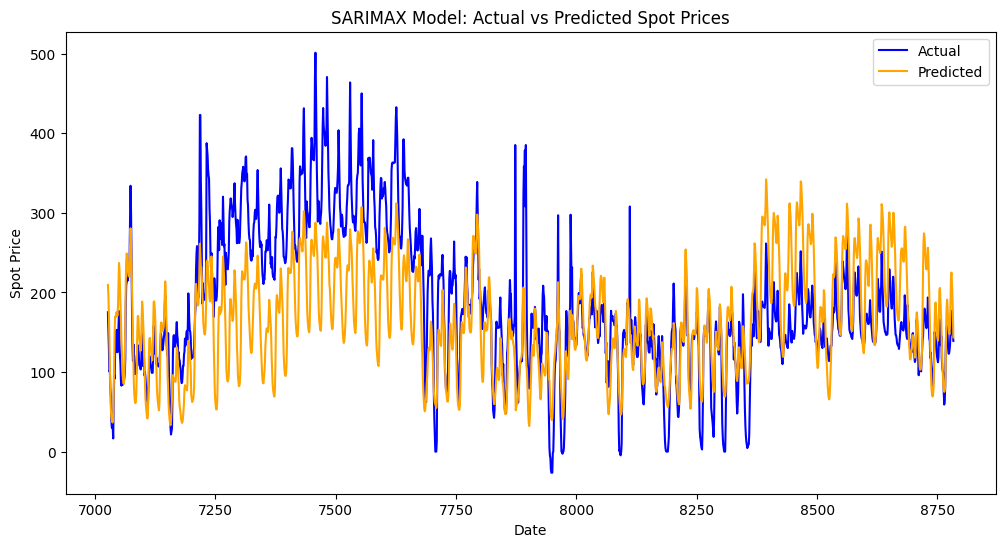

In [7]:
predictions = model.predict(steps=len(y_test), X_test=X_test)


import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(test_data.index, y_test, label='Actual', color='blue')
plt.plot(test_data.index, predictions, label='Predicted', color='orange')
plt.xlabel('Date')
plt.ylabel('Spot Price')
plt.title('SARIMAX Model: Actual vs Predicted Spot Prices')
plt.legend()
plt.show()

# SARIMAX ODG/ECI

In [14]:
from OGD import OGD_Predictor

actuals = y_test

ogd = OGD_Predictor(alpha=0.1, eta=0.5, q_init=50)

for t in range(len(predictions)):
    y_pred = predictions[t]
    y_true = actuals[t]
    
    lower, upper = ogd.get_interval(y_pred)
    covered = ogd.update(y_pred, y_true)
    
    if t % 100 == 0:
        error = abs(y_true - y_pred)
        width = 2 * ogd.q
        threshold = ogd.q
        
    if t % 100 == 0:
        lower, upper = ogd.get_interval(y_pred)
        print(f"t={t}: [{float(lower):.2f}, {float(upper):.2f}], pred={float(y_pred):.2f}, true={float(y_true):.2f}, covered={covered}, q={ogd.q:.2f}")

print("\n ")
print(f"Coverage Rate: {ogd.get_coverage_rate():.3f} (Target: 0.900)")
print(f"Final Threshold: {ogd.q:.2f}")
print(f"Average Width: {np.mean(ogd.threshold_history)*2:.2f}")

misses = sum(1 for c in ogd.coverage_history if not c)
print(f"Total Misses: {misses} out of {len(ogd.coverage_history)}")

t=0: [159.41, 259.31], pred=209.36, true=175.11, covered=True, q=49.95
t=100: [71.73, 174.63], pred=123.18, true=110.15, covered=True, q=51.45
t=200: [90.03, 208.93], pred=149.48, true=192.67, covered=True, q=59.45
t=300: [47.50, 236.40], pred=141.95, true=253.22, covered=False, q=94.45
t=400: [148.35, 379.25], pred=263.80, true=354.17, covered=True, q=115.45
t=500: [96.26, 359.16], pred=227.71, true=334.96, covered=True, q=131.45
t=600: [175.41, 441.31], pred=308.36, true=415.45, covered=True, q=132.95
t=700: [-21.82, 240.08], pred=109.13, true=100.16, covered=True, q=130.95
t=800: [-51.91, 199.99], pred=74.04, true=52.50, covered=True, q=125.95
t=900: [-47.84, 202.06], pred=77.11, true=120.91, covered=True, q=124.95
t=1000: [54.51, 295.41], pred=174.96, true=167.83, covered=True, q=120.45
t=1100: [17.06, 248.96], pred=133.01, true=118.88, covered=True, q=115.95
t=1200: [143.00, 364.90], pred=253.95, true=219.97, covered=True, q=110.95
t=1300: [28.32, 240.22], pred=134.27, true=115.66